### Imports

In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import IPython.display
from IPython.display import Audio
from scipy import signal

from trainDataset import TrainDataset
from testDataset import TestDataset

toFloat = transforms.Lambda(lambda x: x / np.iinfo(np.int16).max)

### Parameters

In [2]:
batch_size = 32
epochs = 5
validation_split = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available(): # adapt those paths on other machine
    path_train = './../data/train-small/'
    path_test =  './../data/test/kaggle-test/'
else:
    path_train = './../../../../challenge_data/kaggle-train/'
    path_test =  './../../../../challenge_data/kaggle-test/'
    
    
inputs_size = 64000 
nmbr_classes = 9
sample_rate = 16000

### Dataset and -loaders

In [3]:
# todo add in the classes the features and the fft data

trainDataset = TrainDataset(path_train, transform=toFloat,
        blacklist_patterns=["synthetic", "string"])
print(len(trainDataset))

testDataset = TestDataset(path_test, transform=toFloat)
print(len(testDataset))

6783
4096


In [13]:
# todo do a validation split here

trainLoader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
for samples, instrument_family_target in trainLoader:
        print(samples.shape, instrument_family_target.shape,
              instrument_family_target.data)
        print(torch.min(samples), torch.max(samples))
        print(trainDataset.transformInstrumentsFamilyToString(instrument_family_target.data))
        break

torch.Size([32, 64000]) torch.Size([32]) tensor([6, 0, 2, 6, 7, 5, 5, 2, 4, 4, 7, 4, 6, 7, 8, 4, 3, 4, 8, 4, 4, 4, 4, 6,
        5, 6, 4, 4, 0, 6, 4, 6])
tensor(-0.9467, dtype=torch.float64) tensor(0.9506, dtype=torch.float64)
['organ' 'bass' 'flute' 'organ' 'reed' 'mallet' 'mallet' 'flute'
 'keyboard' 'keyboard' 'reed' 'keyboard' 'organ' 'reed' 'vocal' 'keyboard'
 'guitar' 'keyboard' 'vocal' 'keyboard' 'keyboard' 'keyboard' 'keyboard'
 'organ' 'mallet' 'organ' 'keyboard' 'keyboard' 'bass' 'organ' 'keyboard'
 'organ']


In [14]:
testloader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False) #!!! shuffle should be false
for samples in testloader:
        print(samples.shape)
        print(torch.min(samples), torch.max(samples))
        break

torch.Size([32, 64000])
tensor(-0.9465, dtype=torch.float64) tensor(0.9469, dtype=torch.float64)


### Look at Data

In [42]:
# how many instruments are there?
instruments_count = np.zeros(20)

for sample in trainDataset:
    instruments_count[sample[1]] += 1

[ 283.  450.  266. 1000. 1845. 1021. 1285.  497.  136.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]


[ 283.  450.  266. 1000. 1845. 1021. 1285.  497.  136.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]


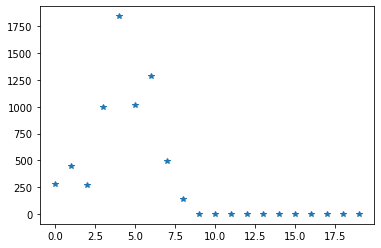

In [44]:
print(instruments_count)
plt.plot(instruments_count, '*')

In [45]:
# plot one of each

done = np.zeros(9)
examples = []

for sample in trainDataset:
    if done[sample[1]] == 0:
        examples.append(sample)
        done[sample[1]] = 1

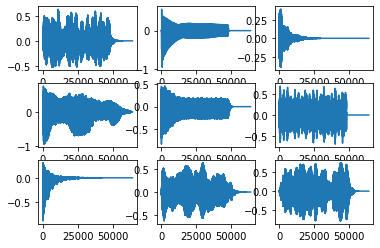

In [50]:
plt.subplot(331)
plt.plot(examples[0][0])

plt.subplot(332)
plt.plot(examples[1][0])

plt.subplot(333)
plt.plot(examples[2][0])

plt.subplot(334)
plt.plot(examples[3][0])

plt.subplot(335)
plt.plot(examples[4][0])

plt.subplot(336)
plt.plot(examples[5][0])

plt.subplot(337)
plt.plot(examples[6][0])

plt.subplot(338)
plt.plot(examples[7][0])

plt.subplot(339)
plt.plot(examples[8][0])

plt.show()

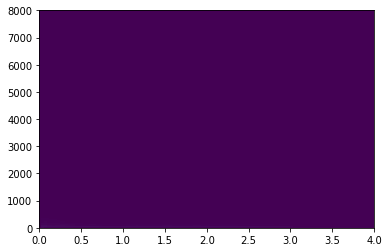

In [62]:
amp = 2 * np.sqrt(2)
f, t, Zxx = signal.stft( examples[1][0], sample_rate, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)

In [55]:
for sample in examples:
    display(Audio(sample[0], rate=sample_rate))

### FNN Model

In [ ]:
class FeedForwardNet(nn.Module):
    """
    simple feed forward net
    2 hidden layer with same node number
    """

    def __init__(self, n_feature, n_hidden, n_output):
        super(FeedForwardNet, self).__init__()
        self.hidden1 = nn.Linear(n_feature, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.out(x)
        return x

    def predict(self, x):
        # Apply softmax to output
        prediction = F.softmax(self.forward(x))  # todo add dimension here
        predicted_labels = []
        # Pick the class with maximum weight
        for t in prediction:
            if t[0] > t[1]:
                predicted_labels.append(0)
            else:
                predicted_labels.append(1)
        return torch.tensor(predicted_labels)


### CNN Model

In [ ]:
class ConvolutionalNet(nn.Module):
    """
    simple convolutional net
    2 conv+pool+relu layer and 3 dense layer
    """

    def __init__(self, channels_1=2, kernel_1=2000, channels_2=4, kernel_2=600):
        super(ConvolutionalNet, self).__init__()
        self.channels_1 = channels_1
        self.channels_2 = channels_2
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2

        # input size: batchsize x 1 x 8192
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.channels_1, kernel_size=self.kernel_1),
            # batchsize x channels_1 x (8192 - 2000 + 1 = 6193)
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3)
            # batchsize x channels_1 x (6193 /3 = 2064 round down)
        )

        self.length_1 = int((8192 - kernel_1 + 1) / 3)

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=channels_1, out_channels=channels_2, kernel_size=self.kernel_2),
            # batchsize x channels_2 x (2064 - 600 + 1 = 1465)
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3)
            # batchsize x channels_2 x (1465 /3 = 488 round down)
        )

        self.length_2 = int((self.length_1 - kernel_2 + 1) / 3)

        self.fc1 = nn.Linear(channels_2 * self.length_2, 512)

        self.fc2 = nn.Linear(512, 84)

        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):

        x = x.view(len(x), -1, len(x[0]))

        out = self.conv1(x)
        out = self.conv2(out)

        out = out.view(x.shape[0], out.size(1) * out.size(2))  # batchsize x channels*length

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return out

    def predict(self, x):
        # Apply softmax to output
        prediction = F.softmax(self.forward(x))  # todo add dimension here
        predicted_labels = []
        # Pick the class with maximum weight
        for t in prediction:
            if t[0] > t[1]:
                predicted_labels.append(0)
            else:
                predicted_labels.append(1)
        return torch.tensor(predicted_labels)